In [4]:
# Import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import graphviz
import seaborn as sns; sns.set()
import pydotplus
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from IPython.display import display
import pickle
from pathlib import Path
import warnings; warnings.filterwarnings("ignore")

In [5]:
# Read data
project_root = Path.cwd().parent
base_path = project_root / "Cheating Dataset"
normal_data = pd.read_csv(base_path / "normal.csv")
cheating_data = pd.read_csv(base_path / "anomaly.csv")
cheating_data["Score / Ans Time"] = cheating_data["Score"] / cheating_data["Ans Time"]
df = pd.concat([normal_data, cheating_data])
df.head()

Av Prev Scores  Paper Swap  Side Glance      Score  Ans Time  \
0       66.244229           0            0  61.337249        35   
1       38.055670           0            0  42.284078        29   
2       36.699750           0            0  40.777500        27   
3       64.100454           0            0  61.048051        41   
4       20.694608           0            0  19.161674        10   

   Score / Ans Time  Cheat  
0          1.752493      0  
1          1.458072      0  
2          1.510278      0  
3          1.488977      0  
4          1.916167      0

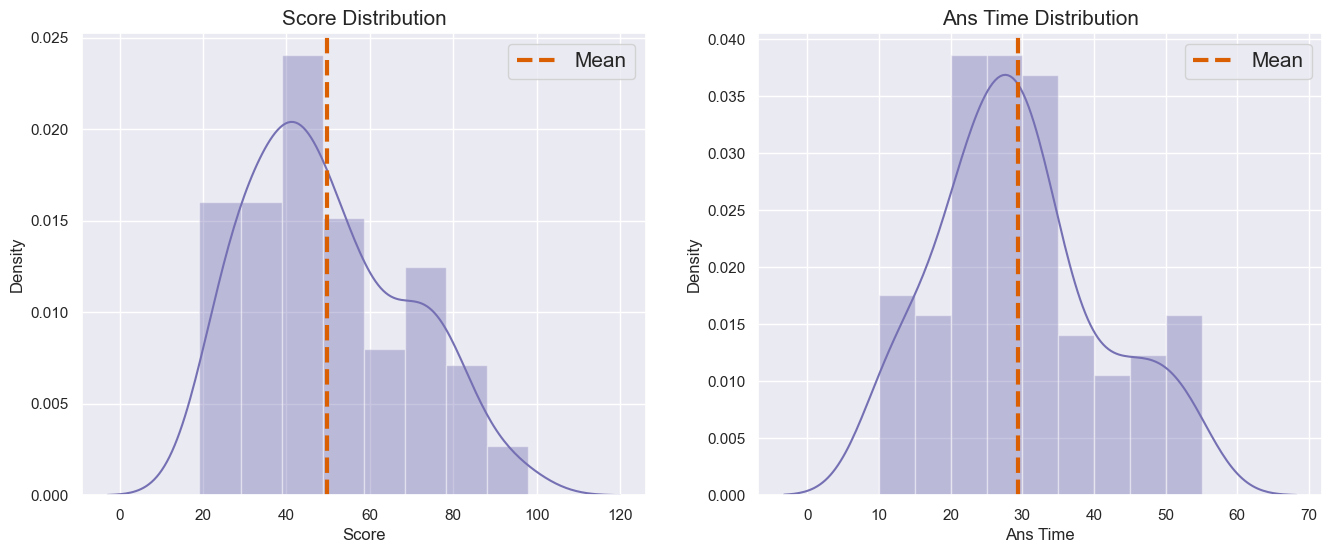

In [6]:
# Plot distributions of "Score" and "Ans Time"
c_palette = sns.color_palette("Dark2")
plt.figure(figsize = (16, 6))
for i, n in zip(["Score", "Ans Time"], [1, 2]):
    plt.subplot(1, 2, n)
    sns.distplot(df[i], color = c_palette[2])
    plt.axvline(df[i].mean(), label = "Mean", ls = "--", lw = 3, c = c_palette[1])
    plt.title(f"{i} Distribution", fontsize = 15)
    plt.legend(fontsize = 15)
plt.show()

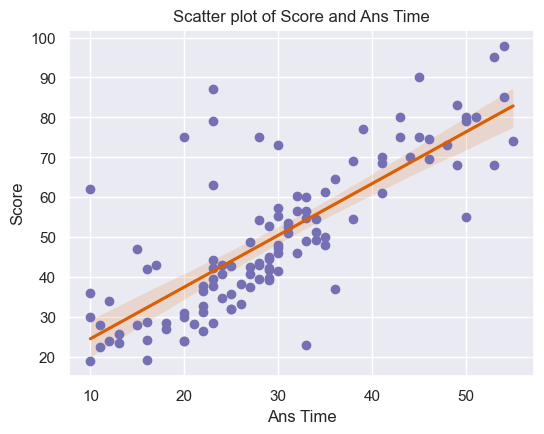

In [7]:
# Regression plot of data
plt.figure(figsize = (6, 4.5))
sns.regplot(x = df["Ans Time"], y = df["Score"], scatter = False, color = c_palette[1])
plt.scatter(df["Ans Time"], df["Score"], color = c_palette[2])
plt.title("Scatter plot of Score and Ans Time")
plt.show()

In [8]:
# Build decision tree function
def build_decision_tree():
    d_tree = DecisionTreeClassifier(criterion = "entropy",
                                    max_depth = None,
                                    min_samples_split = 2,
                                    min_samples_leaf = 1,
                                    max_features = None,
                                    random_state = 42,
                                    max_leaf_nodes = None,
                                    min_impurity_decrease = 0.0)
    return d_tree

# Save decision tree funciton
def save_decision_tree(d_tree, d_tree_file_name):
    project_root = Path.cwd().parent
    base_path = project_root / "Models"
    pickle.dump(d_tree , open(base_path / d_tree_file_name , "wb"))

# Load decision tree function
def load_decision_tree(decision_tree_file_name):
    project_root = Path.cwd().parent
    base_path = project_root / "Models"
    d_tree = pickle.load(open(base_path / decision_tree_file_name, "rb"))
    return d_tree

In [9]:
# Build and train the model
d_tree = build_decision_tree()
d_tree.fit(df.iloc[:, 0 : 6], df["Cheat"])

# Save the tree
save_decision_tree(d_tree, "my_decision_tree.sav")

DecisionTreeClassifier(criterion='entropy', random_state=42)

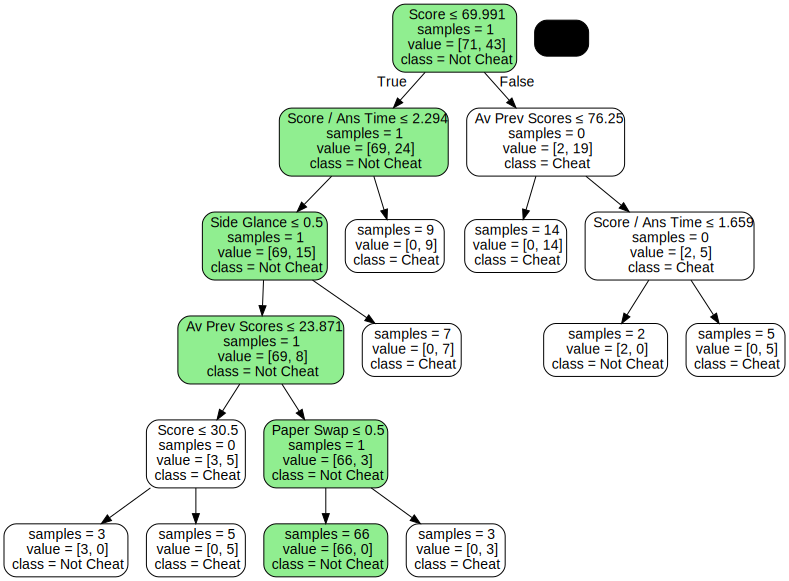

<Figure size 50x50 with 0 Axes>

In [12]:
# Show the path of prediction
def show_path():
    dot_data = tree.export_graphviz(d_tree, out_file = None,
                                    feature_names = df.columns[0 : 6],
                                    class_names = ["Not Cheat", "Cheat"],
                                    filled = True, rounded = True,
                                    impurity = False,
                                    special_characters = True)
    graph = pydotplus.graph_from_dot_data(dot_data)
    
    for node in graph.get_node_list():
        if node.get_attributes().get("label") is None:
            continue
        if "samples = " in node.get_attributes()["label"]:
            labels = node.get_attributes()["label"].split("<br/>")
            for i, label in enumerate(labels):
                if label.startswith("samples = "):
                    labels[i] = "samples = 0"
            node.set("label", "<br/>".join(labels))
            node.set_fillcolor("white")
    
    samples = [[36.69974995,  0.        ,  0.        , 40.77749994, 27.        ,
            1.51027778]]
    decision_paths = d_tree.decision_path(samples)
    
    for decision_path in decision_paths:
        for n, node_value in enumerate(decision_path.toarray()[0]):
            if node_value == 0:
                continue
            node = graph.get_node(str(n))[0]
            node.set_fillcolor("lightgreen")
            labels = node.get_attributes()["label"].split("<br/>")
            for i, label in enumerate(labels):
                if label.startswith("samples = "):
                    labels[i] = "samples = {}".format(int(label.split("=")[1]) + 1)
    
            node.set("label", "<br/>".join(labels))
    plt.figure(figsize = (0.5, 0.5))
    display(graphviz.Source(graph.to_string()))  
    
show_path()